# INTRO

Welcome to our project report for the TechX Intro to ML 2024 session, led by Akwesi Peasare and Divine Faleye designed to guide you through our project on using machine learning to identify important disaster-related tweets. In today's world, Twitter is often the first place where news of emergencies breaks, making it crucial for emergency teams to quickly find and react to real disaster alerts among countless tweets. Our project uses a large collection of tweets, each carefully categorized, to train models that can tell apart real disaster alerts from normal tweets. We aim to develop a tool that helps responders act swiftly and accurately by using insights from social media. Join us as we explore different machine learning techniques to improve how we detect and respond to disaster tweets.

# Disaster Tweet Classifier

Below are some important imports to begin our project with:

In [ ]:
import re
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from collections import defaultdict, Counter
from google.colab import drive
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading Datasets

In [ ]:
#Loading train and test datasets
train_file_path = "/content/drive/MyDrive/train.csv"
test_file_path = "/content/drive/MyDrive/test.csv"

train_df = pd.read_csv(train_file_path)
test_df = pd.read_csv(test_file_path)
display(train_df[31:36])

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


## Data Analysis / Preprocessing
In this project phase, we refine our dataset by removing extraneous elements like URLs and converting emojis to text, enhancing the clarity and relevance of the data. We simplify the text by filtering out repetitive characters and common stopwords, emphasizing key content. Our efforts also include analyzing and adjusting keywords for accurate theme reflection in disaster-related tweets, visualizing data to differentiate disaster from non-disaster tweets, and using n-grams to capture complex linguistic patterns. These steps improve data quality, providing a solid foundation for our predictive models.

### Data clean up
Every URL is removed to focus entirely on the textual content, enhancing the model's ability to learn from linguistic cues rather than hyperlink text. Emojis are translated into descriptive words, converting visual cues into textual data that our models can process.

In [ ]:
# src  "https://web.iitd.ac.in/~jay/dsl810/studentpages/Saksham%20Saxena/Website/projectml.html"
# Pattern matching for url and Emojis

EMOJIS = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

URLPATTERN        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

SEQPATTERN   = r"(.)\1\1+"

In [ ]:
# removing urls and replace emojis with corresponding word representation
def preprocess_text(text):
    """
    Process the input text to prepare it for further analysis or modeling.

    This function removes URLs and sequences of repeated characters, replaces emojis with corresponding text representations,
    tokenizes the text, converts it to lowercase, and removes stopwords. The final text is returned without the stopwords but
    includes modifications made to handle emojis and character sequences.

    Args:
      text (str): The input text string that needs to be preprocessed.

    Returns:
      str: The preprocessed text, which has been cleansed of URLs and unnecessary repetitions, with emojis replaced and converted
    to lowercase, and with stopwords removed.
    """

    text = re.sub(URLPATTERN,"", text)
    text = re.sub(SEQPATTERN, "", text)
    for emoji in EMOJIS.keys():
        text = text.replace(emoji, "EMOJI" + EMOJIS[emoji])

    tokens = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    return text

In [ ]:
# Applying function to preprocess data
train_df['text'] = train_df['text'].apply(preprocess_text)

display(train_df[31:36])

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT,0
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


### Top words in disaster tweets
We adjust keywords by replacing placeholders and removing noise, then analyze the frequency of keywords specifically associated with disaster tweets to identify prevalent themes and terms.

In [ ]:
# Filtering out %20 from tweets and getting top keywords
keyword_dict = defaultdict(int)
train_df['keyword'] = train_df['keyword'].str.replace('%20', ' ', regex=False)
keyword_counts = train_df[train_df['target'] == 1]['keyword'].value_counts().to_dict()
keyword_counts = {k: v for k, v in keyword_counts.items() if v > 20}

print(keyword_counts)

{'derailment': 39, 'wreckage': 39, 'outbreak': 39, 'debris': 37, 'oil spill': 37, 'typhoon': 37, 'evacuated': 32, 'suicide bombing': 32, 'rescuers': 32, 'suicide bomb': 32, 'nuclear disaster': 31, 'razed': 31, 'suicide bomber': 30, 'earthquake': 30, 'airplane accident': 30, 'collision': 29, 'wildfire': 29, 'bridge collapse': 29, 'evacuation': 28, 'buildings on fire': 28, 'mass murder': 28, 'casualties': 28, 'sandstorm': 28, 'drought': 28, 'forest fires': 27, 'devastation': 27, 'hostages': 27, 'bombing': 27, 'wild fires': 27, 'sinkhole': 27, 'famine': 26, 'thunderstorm': 26, 'fatal': 26, 'displaced': 26, 'derailed': 26, 'fatalities': 26, 'floods': 26, 'deaths': 26, 'wounded': 26, 'violent storm': 26, 'massacre': 25, 'attack': 25, 'flooding': 25, 'evacuate': 25, 'heat wave': 25, 'dust storm': 24, 'injured': 24, 'hailstorm': 24, 'terrorism': 24, 'accident': 24, 'buildings burning': 24, 'terrorist': 23, 'structural failure': 23, 'rioting': 23, 'collided': 23, 'bioterror': 22, 'hazardous': 

### Data visualizations
We create visual representations to observe patterns and frequencies that distinguish disaster tweets from non-disaster ones. By visualizing word associations and plotting the distribution of disaster versus non-disaster tweets, we gain insights into the dataset’s balance and the distinct characteristics of each category.

<Axes: xlabel='count', ylabel='keyword'>

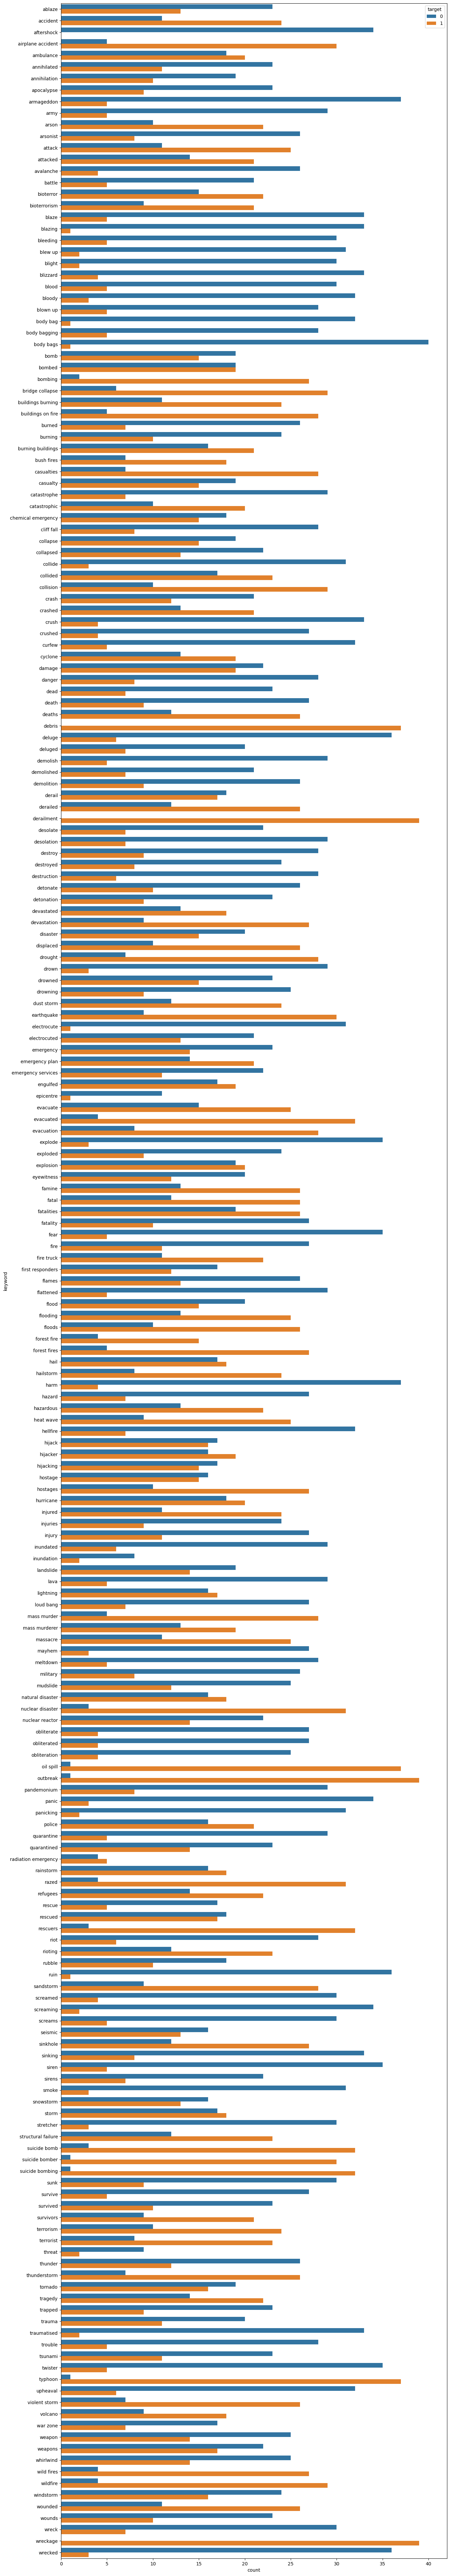

In [ ]:
#Visualizing word association disaster and non-disaster tweets
plt.figure(figsize=(15,100))
sns.countplot(data=train_df, y='keyword', hue='target')

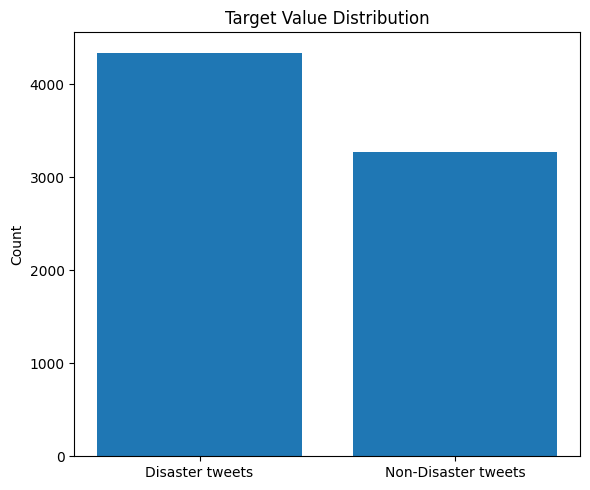

In [ ]:
# Bar chart for count of disaster and nondisaster datapoints
target_counts = train_df['target'].value_counts()

plt.figure(figsize=(6, 5))  # Adjust figure size as needed
plt.bar(target_counts.index, target_counts.values, tick_label=target_counts.index)

# Add labels and title
plt.xticks(ticks=target_counts.index, labels=['Disaster tweets', 'Non-Disaster tweets'])
plt.ylabel('Count')
plt.title('Target Value Distribution')

plt.xticks(rotation=0)  # Ensure horizontal x-axis labels
plt.tight_layout()
plt.show()

### N-grams

Our N-Grams Analysis involves generating n-grams to capture the context within the data that single words might miss. We identify and list the top n-grams in disaster tweets, providing insights into common phrases and the context used during actual emergencies.

In [ ]:
# function to get n-grams

def generate_ngrams(text, n):
  """
  Generates n-grams (sequences of n words) from a given text.

  Args:
      text: The text to generate n-grams from (list of words).
      n: The number of words in the n-gram.

  Returns:
      A list of n-grams.
  """
  ngrams = []
  for i in range(len(text) - n + 1):
    ngrams.append(tuple(text[i:i+n]))
  return ngrams


In [ ]:
#function to get get top n_grams
def get_top_ngrams(texts, n, count=10):
  """
  Gets the top n-grams (most frequent) from a list of texts.

  Args:
      texts: A list of preprocessed text (lists of words).
      n: The n-gram size.
      count: The number of top n-grams to return (default: 10).

  Returns:
      A dictionary containing the top n-grams and their frequencies.
  """
  all_ngrams = []
  for text in texts:
    all_ngrams.extend(generate_ngrams(text, n))

  ngram_counts = Counter(all_ngrams)
  return ngram_counts.most_common(count)


In [ ]:
# Assuming you have separate DataFrames for disaster and non-disaster tweets named 'disaster_tweets' and 'non_disaster_tweets'

# Tokenize text into lists of words
disaster_text_tokens = [word_tokenize(text.lower()) for text in train_df['text']]

# Get top 10-ngrams (2-word n-grams) for disaster tweets
disaster_bigrams = get_top_ngrams(disaster_text_tokens, 10)
print("Top 10 ngrams in Disaster Tweets:")
print(disaster_bigrams)

Top 10 ngrams in Disaster Tweets:
[(('the', 'latest', ':', 'more', 'homes', 'razed', 'by', 'northern', 'california', 'wildfire'), 27), (('latest', ':', 'more', 'homes', 'razed', 'by', 'northern', 'california', 'wildfire', '-'), 26), (('families', 'to', 'sue', 'over', 'legionnaires', ':', 'more', 'than', '40', 'families'), 25), (('to', 'sue', 'over', 'legionnaires', ':', 'more', 'than', '40', 'families', 'affected'), 25), (('sue', 'over', 'legionnaires', ':', 'more', 'than', '40', 'families', 'affected', 'by'), 25), (('over', 'legionnaires', ':', 'more', 'than', '40', 'families', 'affected', 'by', 'the'), 25), (('legionnaires', ':', 'more', 'than', '40', 'families', 'affected', 'by', 'the', 'fatal'), 25), ((':', 'more', 'than', '40', 'families', 'affected', 'by', 'the', 'fatal', 'outbreak'), 25), (('more', 'than', '40', 'families', 'affected', 'by', 'the', 'fatal', 'outbreak', 'of'), 25), (('watch', 'this', 'airport', 'get', 'swallowed', 'up', 'by', 'a', 'sandstorm', 'in'), 24)]


## Baseline
The baseline model classifies tweets based on the presence of predefined disaster-related keywords. If a tweet contains any of these keywords, it's labeled as a disaster; otherwise, it's not. This simple keyword matching approach serves as an initial benchmark for more complex models.

In [ ]:
# key_counts has been already been created in "Top Words In Disaster Tweets" as a dictionary of disaster tweet keywords with more than 20 occurrences

def keyword_baseline(text):
  """
    Classify the input text as a disaster tweet based on the presence of specific keywords.

    This function processes the input text by converting it to lowercase and then checks if any of the predefined keywords,
    which are known to be commonly associated with disaster tweets, are present in the text. If a keyword is found, the text
    is classified as a disaster tweet (returning 1); otherwise, it returns 0.

    Argss:
      text (str): The text of the tweet to be classified.

    Returns:
      int: The classification of the tweet, where 1 indicates a disaster tweet and 0 indicates a non-disaster tweet.

    Notes:
      The `keywords` are derived from a dictionary `keyword_counts` created in the "Top Words In Disaster Tweets" section,
      which contains keywords that occur more than 20 times in disaster-related tweets.
    """
  text = text.lower()
  keywords = keyword_counts.keys()
  for keyword in keywords:
    if keyword in text:
      return 1
    return 0

train_preds = [keyword_baseline(x) for x in train_df['text']]
print('accuracy:', sklearn.metrics.accuracy_score(train_df['target'], train_preds))
print('precision:', sklearn.metrics.precision_score(train_df['target'], train_preds))
print('recall:', sklearn.metrics.recall_score(train_df['target'], train_preds))
print('F1:', sklearn.metrics.f1_score(train_df['target'], train_preds))

accuracy: 0.5755943780375673
precision: 1.0
recall: 0.012228676245796393
F1: 0.024161884627000908


## Train / Test Split

In [ ]:
X = train_df[["text"]].values
Y = train_df["target"].values
# 80 - 20 train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shapes of the train and test data
print("X_train shape:", X_train.shape)
print("y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", Y_test.shape)

print(X_train[0], Y_train[0])

X_train shape: (6090, 1)
y_train shape: (6090,)
X_test shape: (1523, 1)
y_test shape: (1523,)
['Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. '] 1


### Length of Train / Test Split Tweets

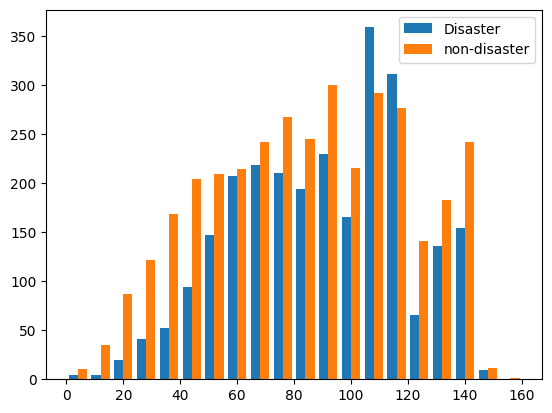

Longest disaster tweet: 151
Longest non-disaster tweet: 152


In [ ]:
# Create a list of lengths for training examples that are disaster tweets.
text_lengths_disaster = [len(x[0]) for (i, x) in enumerate(X_train) if Y_train[i]]

# And a list of lengths for training examples that are not disaster tweets.
text_lengths_non_disaster = [len(x[0]) for (i, x) in enumerate(X_train) if not Y_train[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_disaster, text_lengths_non_disaster], bins=20, range=(0, 160),
         label=['Disaster', 'non-disaster'])
plt.legend()
plt.show()

# Also check the longest tweets.
print('Longest disaster tweet:', max(text_lengths_disaster))
print('Longest non-disaster tweet:', max(text_lengths_non_disaster))

## Data Preparation


### Tweet Dictionary

In [ ]:
def generate_dictionary(tweets):
  """
  Generates a dictionary mapping tokens to unique integer IDs.

  Args:
      tweets: A list of strings (preprocessed tweet texts).

  Returns:
      A dictionary mapping tokens to unique integer IDs.
  """

  word_counts = Counter()
  for tweet in tweets:
    word_counts.update(tweet.split())

  # Ensure special tokens have IDs 1 and 2 (in that order)
  vocab = {'#': 1, '<UNUSED>': 2}
  idx = 3  # Start assigning IDs from 3

  # Add remaining words based on frequency
  for word, count in word_counts.most_common():
    if word not in vocab:  # Skip already added special tokens
      vocab[word] = idx
      idx += 1

  return vocab

# Generate vocabulary for training
index = generate_dictionary(train_df['text'])

# Create a reverse index for token lookup
reverse_index = dict([(value, key) for (key, value) in index.items()])

# Confirm data shapes
max_id = max(reverse_index.keys())
print('Largest ID:', max_id)
print(index)  # Dictionary mapping tokens to IDs
print(reverse_index)  # Dictionary mapping IDs to tokens


Largest ID: 26822
{'#': 1, '<UNUSED>': 2, 'the': 3, 'a': 4, 'to': 5, 'in': 6, 'of': 7, 'and': 8, 'I': 9, 'for': 10, 'is': 11, 'on': 12, '-': 13, 'you': 14, 'The': 15, 'my': 16, 'with': 17, 'that': 18, 'at': 19, 'by': 20, 'it': 21, 'from': 22, 'be': 23, 'was': 24, 'have': 25, 'are': 26, 'this': 27, 'like': 28, '&amp;': 29, 'A': 30, 'as': 31, 'just': 32, 'your': 33, 'up': 34, 'but': 35, 'me': 36, 'so': 37, 'not': 38, 'has': 39, 'out': 40, "I'm": 41, '??': 42, 'will': 43, 'an': 44, 'after': 45, 'via': 46, 'about': 47, 'been': 48, 'get': 49, 'when': 50, 'all': 51, 'or': 52, 'no': 53, 'into': 54, 'over': 55, 'In': 56, '2': 57, 'we': 58, 'who': 59, 'fire': 60, 'people': 61, 'they': 62, 'i': 63, 'if': 64, 'one': 65, 'can': 66, 'he': 67, '|': 68, 'than': 69, "don't": 70, 'more': 71, 'do': 72, 'what': 73, 'were': 74, 'would': 75, "it's": 76, 'his': 77, 'her': 78, 'how': 79, 'This': 80, 'To': 81, 'now': 82, 'new': 83, 'got': 84, 'off': 85, 'New': 86, 'know': 87, 'You': 88, 'had': 89, 'My': 90, '

### Pad Data

In [ ]:
def pad_data(sequences, max_length):
  return np.array(list(
    tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_length, padding='post', value='#', dtype=object)))

### Limit Vocabulary

In [ ]:
def limit_vocab(sequences, max_token_id, index):
  """
  Limits the vocabulary in a sequence to only include tokens with IDs less than max_token_id.
  Tokens with IDs greater than or equal to max_token_id are replaced with the out-of-vocabulary (oov) token '#'.

  Args:
      sequences: A NumPy array of shape (num_sequences, max_sequence_length) containing integer token IDs.
      max_token_id: An integer representing the maximum token ID to include in the vocabulary.
      index: A dictionary mapping tokens to their corresponding integer IDs (vocabulary).

  Returns:
      A NumPy array of the same shape (num_sequences, max_sequence_length) with tokens limited to the vocabulary.
  """
  reduced_sequences = np.copy(sequences)  # Create a copy of the input sequences array
  for i in range(len(reduced_sequences)):
    for j in range(len(reduced_sequences[i])):
      # Check if token is out-of-vocabulary (oov)
      if not(reduced_sequences[i][j] in index) or index.get(reduced_sequences[i][j]) >= max_token_id:
        reduced_sequences[i][j] = '#'
    return reduced_sequences  # Return the reduced sequences array

## Experiment 1

In this method we split the train inputs into tokens and pad them up to have equal lengths, 160. We then encode the words and run with the Global average pooling.

### Tokenization Implementation I

In [ ]:
# split entry to individual tokens
def split_entry(sequence):
  output = []
  for tweet in sequence:
    value = tweet[0].split()
    output.append(value)
  return output

In [ ]:
X_train_split = split_entry(X_train.tolist())
X_test_split = split_entry(X_test.tolist())

train_padded = pad_data(X_train_split, 160 )
test_padded = pad_data(X_test_split, 160)

In [ ]:
train_reduced = limit_vocab(train_padded, 25000, index)
test_reduced = limit_vocab(test_padded, 25000, index)
print("Train:", train_reduced.shape, "Test:", test_reduced.shape, "\n")
display(train_reduced[0])

Train: (6090, 160) Test: (1523, 160) 



array(['Courageous', 'and', 'honest', 'analysis', 'of', 'need', 'to',
       'use', 'Atomic', 'Bomb', 'in', '1945.', '#Hiroshima70', 'Japanese',
       'military', 'refused', 'surrender.', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#',
       '#', '#', '#', '#', '#', '#', '#'], dtype=object)

### Encoding Method 1

In [ ]:
def encode_vocab(sequences, index):
  """
  Encodes sequences of tokens into their corresponding integer IDs using a vocabulary dictionary.

  Args:
      sequences: A NumPy array of shape (num_sequences, max_sequence_length) containing tokens.
      index: A dictionary mapping tokens to their corresponding integer IDs (vocabulary).

  Returns:
      A NumPy array of the same shape (num_sequences, max_sequence_length) with tokens replaced by their integer IDs.
  """
  encoded_sequences = np.copy(sequences)

  # Loop through each sequence and each token
  encoded_sequences = np.copy(sequences)

  # Loop through each sequence and each token
  for i in range(len(encoded_sequences)):
    for j in range(len(encoded_sequences[i])):
      encoded_sequences[i][j] = index.get(encoded_sequences[i][j], 2)  # Using 2 for missing keys

  # Convert to float32
  encoded_sequences = encoded_sequences.astype('float32')
  return encoded_sequences


In [ ]:
train_encoding = encode_vocab(train_reduced, index)
test_encoding = encode_vocab(test_reduced, index)

print("Train:", train_encoding.shape, "Test:", test_encoding.shape, "\n")
print(train_encoding[0])


Train: (6090, 160) Test: (1523, 160) 

[2.1085e+04 8.0000e+00 2.1086e+04 2.1087e+04 7.0000e+00 1.4700e+02
 5.0000e+00 4.8700e+02 4.2300e+02 1.0700e+03 6.0000e+00 7.3630e+03
 2.1088e+04 1.3760e+03 4.5100e+02 4.9080e+03 2.1089e+04 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00 1.0000e+00
 1.0000e+00 1.0000e+00 

### Model 1

In [ ]:
def build_embeddings_model(vocab_size, sequence_length, embedding_dim):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.keras.utils.set_random_seed(0)
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length, trainable=True))
  model.add(tf.keras.layers.GlobalAveragePooling1D())

  # Sigmoid activation layer
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
  model.add(tf.keras.layers.Dense(
      units=1,
      activation='sigmoid'
  ))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

  return model

In [ ]:
# Function for plotting the learning curves given the training history object we get from Keras. # Taken from HW / lab code.
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()



Epoch 1/5
172/172 [==============================] - 6s 25ms/step - loss: 0.6845 - accuracy: 0.5694 - val_loss: 0.6838 - val_accuracy: 0.5698
Epoch 2/5
172/172 [==============================] - 4s 21ms/step - loss: 0.6834 - accuracy: 0.5694 - val_loss: 0.6810 - val_accuracy: 0.5698
Epoch 3/5
172/172 [==============================] - 4s 26ms/step - loss: 0.6130 - accuracy: 0.6557 - val_loss: 0.5110 - val_accuracy: 0.7619
Epoch 4/5
172/172 [==============================] - 3s 20ms/step - loss: 0.3884 - accuracy: 0.8418 - val_loss: 0.4658 - val_accuracy: 0.7882
Epoch 5/5
172/172 [==============================] - 3s 20ms/step - loss: 0.2513 - accuracy: 0.9082 - val_loss: 0.4846 - val_accuracy: 0.8030


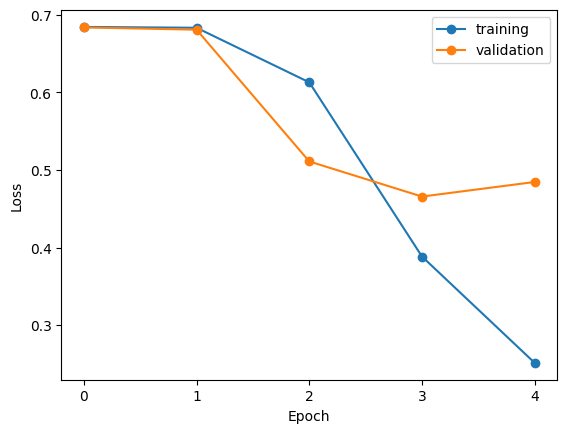

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 50)           1341100   
                                                                 
 global_average_pooling1d (  (None, 50)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                1632      
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                        

In [ ]:
model_1 = build_embeddings_model(vocab_size=26822,
                               sequence_length=160,
                               embedding_dim=50)


# Fit the model.
history = model_1.fit(
  x = train_encoding,
  y = Y_train,
  epochs=5,
  batch_size=32,
  validation_split=0.1,
  verbose=1
  )
history = pd.DataFrame(history.history)
plot_history(history)
model_1.summary()

## Experiment 2

In this method we vectorize the tokens using a different method. We then create a one-hot vector and build a model using sigmoid activation

### Vectorization Implementation I

In [ ]:
text_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=26822,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    output_mode='int',
)

# Fit the TextVectorization layer to the training data
text_vectorization.adapt(X_train)

# Apply transformation to train data
X_train_vector = text_vectorization(X_train)

print(X_train_vector.shape)
print(X_train_vector[0])

# Apply transformation to test data
X_test_vector = text_vectorization(X_test)

print(X_test_vector.shape)
print(X_test_vector[0])


(6090, 31)
tf.Tensor(
[13476     8  4919  2905     6   156     5   436   214   118     4  2935
  4930  1176   238  4365  4105     0     0     0     0     0     0     0
     0     0     0     0     0     0     0], shape=(31,), dtype=int64)
(1523, 30)
tf.Tensor(
[ 29  12  23   3  51 259  15  70 263   1 423   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)


### One Hot Vector

In [ ]:
max_len = max(len(x) for x in X_train_vector)

X1_train_onehot = pad_sequences(X_train_vector, maxlen=max_len, padding='post')
X1_test_onehot = pad_sequences(X_test_vector, maxlen=max_len, padding='post')
print(X1_train_onehot[0], X1_train_onehot.shape)

[13476     8  4919  2905     6   156     5   436   214   118     4  2935
  4930  1176   238  4365  4105     0     0     0     0     0     0     0
     0     0     0     0     0     0     0] (6090, 31)


### Model 2

In [ ]:
def create_and_train_embedding_model(X_train, Y_train, X_test, Y_test, max_len, embedding_dim=4, epochs=5, batch_size=32, validation_split=0.2):
    model_embedding = Sequential([
        Embedding(input_dim=26822, output_dim=embedding_dim, input_length=max_len),
        Flatten(),
        Dense(units=32, activation='sigmoid'),
        Dense(units=1, activation='sigmoid')
    ])

    model_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_embedding.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split)

    y_pred_embedding = (model_embedding.predict(X_test) > 0.6).astype("int32")

    accuracy = accuracy_score(Y_test, y_pred_embedding)
    report = classification_report(Y_test, y_pred_embedding)

    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)

    return model_embedding, accuracy, report

model_2, accuracy, report = create_and_train_embedding_model(X1_train_onehot, Y_train, X1_test_onehot, Y_test, max_len)

Epoch 1/5
153/153 [==============================] - 2s 5ms/step - loss: 0.6874 - accuracy: 0.5470 - val_loss: 0.6673 - val_accuracy: 0.5878
Epoch 2/5
153/153 [==============================] - 1s 5ms/step - loss: 0.6009 - accuracy: 0.7007 - val_loss: 0.5469 - val_accuracy: 0.7553
Epoch 3/5
153/153 [==============================] - 1s 4ms/step - loss: 0.4371 - accuracy: 0.8397 - val_loss: 0.4767 - val_accuracy: 0.7824
Epoch 4/5
153/153 [==============================] - 1s 5ms/step - loss: 0.3120 - accuracy: 0.8896 - val_loss: 0.4640 - val_accuracy: 0.7865
Epoch 5/5
48/48 [==============================] - 0s 3ms/step
Accuracy: 0.7977675640183848

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       874
           1       0.81      0.69      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80    

## Experiment 3
Here again we flatten each entry and tokenize the words using a different method from Method 1. We then create a one-hot vector and train a model using the embedding layer, flatten layer and dense layer.

### Flatten data

In [ ]:
X_train_flattened = [item for sublist in X_train for item in sublist]
X_test_flattened = [item for sublist in X_test for item in sublist]
print(X_train_flattened)


['Courageous and honest analysis of need to use Atomic Bomb in 1945. #Hiroshima70 Japanese military refused surrender. ', '@ZachZaidman @670TheScore wld b a shame if that golf cart became engulfed in flames. #boycottBears', "Tell @BarackObama to rescind medals of 'honor' given to US soldiers at the Massacre of Wounded Knee. SIGN NOW &amp; RT! ", 'Worried about how the CA drought might affect you? Extreme Weather: Does it Dampen Our Economy? ', '@YoungHeroesID Lava Blast &amp; Power Red #PantherAttack @JamilAzzaini @alifaditha', "Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were ", 'Our builder is having a dental emergency. Which has ruined my plan to emotionally blackmail him this afternoon with my bump.', 'BMX issues Areal Flood Advisory for Shelby [AL] till Aug 5 9:00 PM CDT ', "#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? ", "@RobertONeill31 Getting hit by a foul ball while sitting there is hard

### Tokenization Implementation II

In [ ]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_flattened)

X_train_seq = tokenizer.texts_to_sequences(X_train_flattened)
X_test_seq = tokenizer.texts_to_sequences(X_test_flattened)

vocab_size = len(tokenizer.word_index) + 1
max_len = max(len(x) for x in X_train_seq)

X_train_onehot = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_onehot = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
print(X_train_onehot[0], X_train_onehot.shape)

[5902    7 3943 2430    5  163    4  400  223  123    3 2083 3944 1166
  251 3945 3946    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0] (6090, 33)


### Model 3

In [ ]:
def create_and_train_embedding_model(X_train_onehot, Y_train, X_test_onehot, Y_test, vocab_size, max_len, embedding_dim=5, epochs=5, batch_size=32):
    model_embedding = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

    model_embedding.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    model_embedding.fit(X_train_onehot, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    y_pred_embedding = (model_embedding.predict(X_test_onehot) > 0.5).astype("int32")

    accuracy = accuracy_score(Y_test, y_pred_embedding)
    report = classification_report(Y_test, y_pred_embedding)

    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", report)

    return accuracy, report


In [ ]:
accuracy, report = create_and_train_embedding_model(X_train_onehot, Y_train, X_test_onehot, Y_test, vocab_size, max_len)

Epoch 1/5
153/153 [==============================] - 2s 5ms/step - loss: 0.6795 - accuracy: 0.5669 - val_loss: 0.6636 - val_accuracy: 0.5928
Epoch 2/5
153/153 [==============================] - 1s 3ms/step - loss: 0.6077 - accuracy: 0.6929 - val_loss: 0.5800 - val_accuracy: 0.7414
Epoch 3/5
153/153 [==============================] - 1s 3ms/step - loss: 0.4814 - accuracy: 0.8333 - val_loss: 0.5101 - val_accuracy: 0.7726
Epoch 4/5
153/153 [==============================] - 1s 4ms/step - loss: 0.3769 - accuracy: 0.8762 - val_loss: 0.4810 - val_accuracy: 0.7849
Epoch 5/5
48/48 [==============================] - 0s 2ms/step
Accuracy: 0.7977675640183848

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.83       874
           1       0.82      0.68      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79    

## Experiment 4

Here we vectorize the tokens using a different way from method 2. We then build a model using

### Vectorization Implementation II

In [ ]:
X = train_df["text"].values
Y = train_df["target"].values

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=20000)
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Train-test split
X_train_tfidf, X_test_tfidf, Y_train, Y_test = train_test_split(X_tfidf, Y, test_size=0.2, random_state=42)

### Model 4

In [ ]:
def build_onehot_model():
    """Build a tf.keras model for one-hot data."""
    # Clear session and remove randomness.
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(units=32, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model



In [ ]:
def plot_history(history):
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.xticks(range(0, len(history['loss']) + 1))
    plt.plot(history['loss'], label="training", marker='o')
    plt.plot(history['val_loss'], label="validation", marker='o')
    plt.legend()
    plt.show()

Epoch 1/6
86/86 [==============================] - 2s 17ms/step - loss: 0.7040 - accuracy: 0.5300 - val_loss: 0.6777 - val_accuracy: 0.5698
Epoch 2/6
86/86 [==============================] - 2s 21ms/step - loss: 0.6735 - accuracy: 0.5694 - val_loss: 0.6698 - val_accuracy: 0.5698
Epoch 3/6
86/86 [==============================] - 2s 21ms/step - loss: 0.6610 - accuracy: 0.5694 - val_loss: 0.6566 - val_accuracy: 0.5796
Epoch 4/6
86/86 [==============================] - 1s 17ms/step - loss: 0.6383 - accuracy: 0.6086 - val_loss: 0.6314 - val_accuracy: 0.6749
Epoch 5/6
86/86 [==============================] - 1s 14ms/step - loss: 0.5958 - accuracy: 0.7192 - val_loss: 0.5881 - val_accuracy: 0.7356
Epoch 6/6
86/86 [==============================] - 1s 14ms/step - loss: 0.5277 - accuracy: 0.8203 - val_loss: 0.5308 - val_accuracy: 0.7833


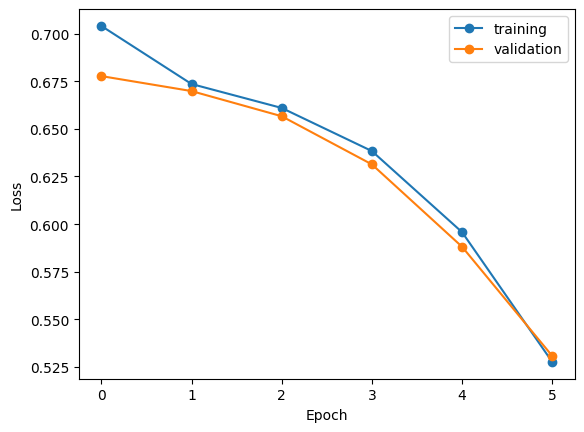

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 17014)             0         
                                                                 
 dense (Dense)               (None, 32)                544480    
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 545569 (2.08 MB)
Trainable params: 545569 (2.08 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Build and train the model without averaging over positions
model_4 = build_onehot_model()

# Fit the model.
history = model_4.fit(
    x = X_train_tfidf.toarray(),  # TF-IDF training data
    y = Y_train,          # corresponding binary labels
    epochs=6,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_split=0.1, # use a fraction of the examples for validation
    verbose=1             # display some progress output during training
)

history_df = pd.DataFrame(history.history)
plot_history(history_df)
model_4.summary()



# Model Choice

## Reasoning

Our final model selection is model 4 because it is the most generalized of all the model experiments with 0.8203 accuracy on training data and 0.7833 on validation data. Unlike model 2 which seems to overfit model 4 does not. The plot also shows a decrease in loss with each training epoch for model 4.

## Train And Test Predictions

In [ ]:
test_predictions = model_4.predict(X_test_tfidf.toarray()).flatten()
print(Y_test.shape == test_predictions.shape)
display(test_predictions)

train_predictions = model_4.predict(X_train_tfidf.toarray()).flatten()
display(test_predictions)

48/48 [==============================] - 0s 4ms/step
True


array([0.25012153, 0.3131603 , 0.40647048, ..., 0.62752825, 0.74198204,
       0.38950437], dtype=float32)

191/191 [==============================] - 1s 4ms/step


array([0.25012153, 0.3131603 , 0.40647048, ..., 0.62752825, 0.74198204,
       0.38950437], dtype=float32)

## Finding The Optimal Threshold From ROC Curve
Youden’s index is considered the optimal threshold obtained by subtracting the false positive rate from the true positive rate obtained from our ROC curve

In [ ]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay


#Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(Y_train, train_predictions)

# Finding the optimal threshold
# Maximize the Youden's index
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]


roc_auc = auc(fpr, tpr)

print("Optimal Threshold (Youden's index):", optimal_threshold)
print("Area Under Curve (AUC):", roc_auc)


Optimal Threshold (Youden's index): 0.4024068
Area Under Curve (AUC): 0.9452508254614271


## Binary Predictions Of Train Data

In [ ]:
binary_predictions = (train_predictions >= optimal_threshold).astype(int)
print("Accuracy: ", accuracy_score(Y_train, binary_predictions))
print("Precision: ", precision_score(Y_train, binary_predictions))
print("Recall: ", recall_score(Y_train, binary_predictions))


Accuracy:  0.8848932676518884
Precision:  0.8664631819916062
Recall:  0.8661327231121282


## Binary Predictions Of Test Data With Confusion Matrix

Accuracy:  0.7767564018384767
Precision:  0.7288888888888889
Recall:  0.7580893682588598


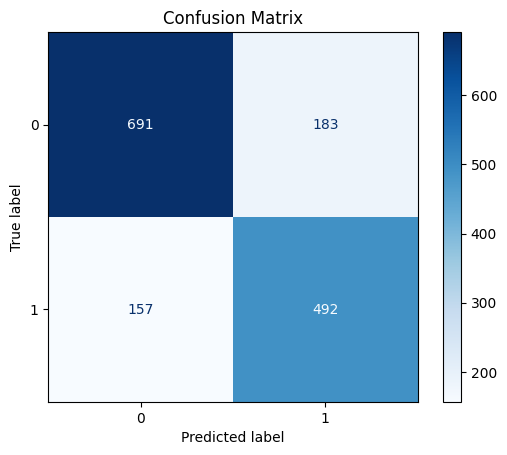

In [ ]:
binary_predictions = (test_predictions >= optimal_threshold).astype(int)
cm = confusion_matrix(Y_test, binary_predictions)

print("Accuracy: ", accuracy_score(Y_test, binary_predictions))
print("Precision: ", precision_score(Y_test, binary_predictions))
print("Recall: ", recall_score(Y_test, binary_predictions))


# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Error Analysis

In [ ]:
#Examination of errors

# Extract indices of false positives and false negatives
false_positives = np.where((binary_predictions == 1) & (Y_test == 0))[0]
false_negatives = np.where((binary_predictions == 0) & (Y_test == 1))[0]

# Extract the tweet texts for false positives and false negatives
false_positive_texts = X_test[false_positives]
false_negative_texts = X_test[false_negatives]

# Printing the False Positives
print("False Positive Tweets: \n")
print(false_positive_texts[0:10])

False Positive Tweets: 

[['in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3']
 ['ON THE USE OF PERFORATED METAL SHEAR PANEL SFOR SEISMIC-RESISTANT APPLICATIONS ']
 ['Who is bringing the tornadoes and floods. Who is bringing the climate change. God is after America He is plaguing her\n \n#FARRAKHAN #QUOTE']
 ['@MyVintageSoul of the British upper class and his manservant.  The pampered wealthy Brit causes a catastrophic shift (reversal) of']
 ["she's a suicide bomb"]
 ['Dear @CanonUSAimaging I brought it EMOJIwink #CanonBringIt #Fire  #CanonTattoo #MN #TheresMoreWhereThatCameFrom ']
 ['When your heart is bigger than the obstacles  in front of you #euro #dontexpectnothing #july #fire @euro']
 ['Magic City Mayhem: Kissimmee adventures ? Aug. 5 2015 ']
 ['Social Casualty #MTVHottest 5SOS']
 ['NHS England announces new plan to meet emergency care targets ']]


##False Positives
1. **"she's a suicide bomb:"**

The words "suicide" and "bomb" carry strong weights typically associated with disaster-related contexts, leading to misclassification. Despite lacking enough context, this tweet could actually be more metaphorical.

2. **"I'm hungry as a hostage:"**

The use of "hostage" might trigger disaster-related classification due to its typical association with crisis situations, leading to misclassification. However this tweet was made out of dark humor as against being a disaster tweet.

3. **"I See Fire", "I'm On Fire.:"**

"Fire" ranked as one of the top keywords associated with disaster-related tweets even during our data analysis/ preprocessing. With the lack of context, behind these short tweets it makes it quite reasonable for this misclassification even though these words may have come straight from a literature soure(poem, novel,music etc)

4. **"@CaIxxum5SOS thanks for the damn heart attack:"**

The phrase "heart attack" is commonly associated with medical emergencies leading to our model's classification into a disaster tweet. However, in this context, it's more reflective of  shock or surprise, not an actual medical emergency.

5. **"I rated Catastrophe (2015) 8/10 #IMDb - hilarious!:"**

This tweet is a rating of TV show or movie, Catastrophe. However, when the word "Catastrophe" is taken in isolation is a typical disaster keyword, that will carry more weight ideally even against the word "hilarious" in this tweet.



##False Positive Error Analysis

From the extensive study of the false positives and their error analysis, the following deductions can be made:

1. Many tweets use dramatic or figurative language for effect or emotion but are not literally discussing disasters. Our model fails sometimes to recognize the context/sentence structures

2. Also our model fails to capture jargons or media references used in tweets(e.g "Black Eye 9: A space battle occurred")

3. The model exaggerates words commonly associated with disasters, such as "explode," "catastophe" and commonly takes them out of broader contexts

In [ ]:
# Printing the False Positives
print("\nFalse Negative Tweets: \n")
print(false_negative_texts[0:10])


False Negative Tweets: 

[['So you have a new weapon that can cause un-imaginable destruction.']
 ['my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite ']
 ['@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS']
 ["@Kinder_Morgan can'twon't tell @cityofkamloops how they'd respond to an oil spill. Trust them? See Sec 4.2 #Kamloops "]
 ['Pandemonium In Aba As Woman Delivers Baby Without Face (Photos) - ']
 ["It's a miracle that mankind survived 70 years since one of the worst days in its history. All bets are off if it will survive the next 70."]
 ["@pattonoswalt @FoxNews Wait I thought Fecal Hurricane was on SciFi? Maybe that was turdnado. I've been forgeting up a shit storm lately."]
 ["'The Reagan Administration had arranged for Israeli weapons to be sent to the Guatemalan Army  "]
 ["@PhilipDuncan @breakfastone People 'annihilated by last nights w

## False Negatives

1. **".@Emily_Noel95 @SterlingKnight @joeylawrence @ABCFmelissajoey that car crash was pretty fun to film #melissaandjoeychat":**

This tweet mentions a "car crash," typically a disaster-related term. However, the context here is about filming a scene for a television show, making it non-disaster-related despite the use of the term. The model's failure to pick up on this non-literal usage resulted in a false negative.

2. **"Nigga This Is The First Time I Heard A Song By Justine Sky Other Than Collide":**

The tweet here uses a racial slur but the model overlooked the slur reference, erroneously interpreting it as non-disaster related.


3. **"@NTSouthWest Looks very tasty but the problem is the cliff might fall into the sea due to coastal erosion so it would be crumbly then":**

This tweet subtly mentions a potential natural disaster (cliff falling due to erosion), but the light-hearted tone about the food's texture ("crumbly") may mislead the model into not recognizing the serious underlying disaster threat.


4. **"What if your hometown were hit by the Hiroshima atomic bomb?":**

Despite clearly discussing a devastating historical event, the hypothetical nature of this tweet ("What if") might cause the model to misclassify it. The model may not recognize the severity due to the speculative framing rather than a report of an actual event.

##False Negative Error Analysis
From the extensive study of the false positives and their error analysis, the following deductions can be made:
1. The model inconsistently detects disasters across tweets that have a similar structure but different content. This inconsistency might stem from an uneven representation of similar contexts in the training data or from inadequate feature extraction that fails to capture essential similarities. A comparison with the false positives, proves this more as to how it is inconsistent. Tweets with similar context and structure (some very obvious) were inconsistently classified.

2. The model struggles to differentiate between metaphorical expressions and actual disaster reports

3. The model fails to catch subtler mentions of actual disasters when they are embedded in casual or indirect language. For example, "Just happened a terrible car crash" is straightforward but was missed possibly due to its informal phrasing

4. References to specific incidents, such as "AHiroshima atomic bomb", are not recognized as pertaining to actual disasters.

## How To Address Errors

We did compute the N-grams for our datasets but never used it to train our function model here. On that note, incorporating contextual embeddings or expanding the feature set to include bi-grams or tri-grams might help capture more complex language patterns and reduce misclassifications.


Also the model was overly sensitive to specific keywords associated with disasters without considering the broader context or metaphorical language. This suggests a need for more nuanced language processing techniques that can interpret context better, or training on a dataset with more varied uses of language to improve the model’s ability to discern between literal and figurative expressions.

# Results


Model | Accuracy | Precision | Recall
--- | --- | --- | ---
Baseline | 0.5756 | 1.0000 | 0.0122
Model 4 | 0.7768 | 0.7289 | 0.7581

NB: Model 4 results are from test results of train/test split
  